<a href="https://colab.research.google.com/github/samiNCL/ML/blob/main/SamiDay4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:



from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
from google.colab import files

data = scipy.io.loadmat('/content/drive/MyDrive/PAMAP2.mat')


In [18]:
import numpy as np
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K

np.random.seed(2)



#data = scipy.io.loadmat('PAMAP2.mat')
Xy_train0 = data['Xy_train']
Xy_test0 = data['Xy_test']


print('including MLP/CNN/LSTM/ConvLSTM')


including MLP/CNN/LSTM/ConvLSTM


In [19]:
print('in DL, it is crucial to perform channel-wise normalisation')
mn = np.mean(Xy_train0[:,:-1], axis=0)
#print(mn.shape)
std = np.std(Xy_train0[:,:-1], axis=0)
#print(std.shape)
Xy_train0[:,:-1] = (Xy_train0[:,:-1]-mn)/std
Xy_test0[:,:-1] = (Xy_test0[:,:-1]-mn)/std


in DL, it is crucial to perform channel-wise normalisation


In [20]:
cNum=12
win_len = 100
dim = Xy_train0.shape[1]-1 #minus the label col
print(dim)


27


In [21]:
def sliding_window(Xy, percentage=0.5, win_len=100):
    #print('per')
    print('overlapping_percentage:  '+str(percentage*100)+'%')

    batch_size0 = int(np.floor(len(Xy)/win_len))
    #print(batch_size0)
    Xy0 = Xy[:win_len*batch_size0,:]
    if percentage==1:
        print('100% overlapping means no overlapping')
        return Xy0

    K_fold = int(1/(1-percentage))
    #print(K_fold)
    offset = int(np.round(win_len * (1-percentage)))
    Xy_big = []
    for k in range(K_fold):
        #print(k)
        current_set = Xy0[k*offset:len(Xy0)-(win_len-k*offset),:]
        #print(len(current_set))
        Xy_big.append(current_set)
    return np.concatenate(Xy_big)

def _to_frames(Xy, dim, win_len=100):
    X3D = np.reshape(Xy[:,:-1], (-1, win_len, dim))
    y2D = np.reshape(Xy[:,-1],(-1, win_len)).astype(int)
    y = np.zeros(len(y2D))
    for i in range(len(y2D)):
        counts = np.bincount(np.reshape(y2D[i, :], (-1)))
        y[i] = np.argmax(counts)
    return X3D, y


In [22]:
print(Xy_train0.shape)
Xy_train = sliding_window(Xy_train0, 0.5, win_len)
print(Xy_train.shape)
X_train0, y_train0 = _to_frames(Xy_train,dim, win_len)


print(Xy_test0.shape)
Xy_test = sliding_window(Xy_test0, 0.5, win_len)
print(Xy_test.shape)
X_test0, y_test0 = _to_frames(Xy_test,dim,win_len)


(473445, 28)
overlapping_percentage:  50.0%
(946600, 28)
(174180, 28)
overlapping_percentage:  50.0%
(348000, 28)


In [23]:
Xy_train.shape


(946600, 28)

class 0, sample number 275, percentage 2.9%
class 1, sample number 971, percentage 10.3%
class 2, sample number 902, percentage 9.5%
class 3, sample number 957, percentage 10.1%
class 4, sample number 1205, percentage 12.7%
class 5, sample number 337, percentage 3.6%
class 6, sample number 797, percentage 8.4%
class 7, sample number 901, percentage 9.5%
class 8, sample number 596, percentage 6.3%
class 9, sample number 540, percentage 5.7%
class 10, sample number 867, percentage 9.2%
class 11, sample number 1118, percentage 11.8%


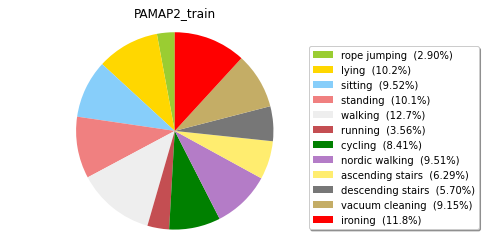

class 0, sample number 50, percentage 1.4%
class 1, sample number 313, percentage 9.0%
class 2, sample number 333, percentage 9.6%
class 3, sample number 309, percentage 8.9%
class 4, sample number 384, percentage 11.0%
class 5, sample number 317, percentage 9.1%
class 6, sample number 301, percentage 8.6%
class 7, sample number 353, percentage 10.1%
class 8, sample number 183, percentage 5.3%
class 9, sample number 161, percentage 4.6%
class 10, sample number 303, percentage 8.7%
class 11, sample number 473, percentage 13.6%


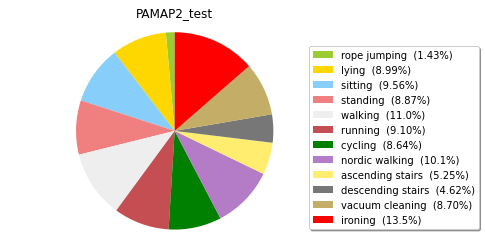

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
def drawing_pie_chart(percentages, labels, dataset_id):
    plt.title(dataset_id)
    color_set = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral',
            '#eeeeee','#C44E52', 'green', '#B47CC7','#ffed6f','#777777','#C4AD66','red', 
                  'blue',  'cyan', 'magenta',
                '#FBC15E','#56B4E9','#4878CF','#FFFEA3' ]
    
    labels = labels.copy()
    for i in range(len(percentages)):
        labels[i] = labels[i]+'  ('+str(percentages[i])[:4]+'%)'
    colors = color_set[:len(percentages)]
    
    
    patches, texts = plt.pie(percentages, colors=colors, startangle=90)
    
    plt.axis('equal')
    lgd = plt.legend(labels, loc=(0.9, 0.05), shadow=True, borderaxespad=10.)
    
    
    #plt.savefig('dataset_'+dataset_id+'.eps', bbox_extra_artists=(lgd,), bbox_inches='tight', format='eps', dpi=600)
    plt.show()
    
def calculating_percentages(y_, cNum):
    percentages = np.zeros(cNum)
    for i in range(cNum):
        num = np.sum(y_==i)
        percentages[i]=100.0*num/len(y_)
        print('class {}, sample number {}, percentage {:.1f}%'.format(i, num, percentages[i]))
    return percentages


dataset_id = 'PAMAP2'
labels_PAMAP2 = [r'rope jumping', 
                 r'lying', 
                 r'sitting', 
                 r'standing',
                 r'walking', 
                 r'running', 
                 r'cycling', 
                 r'nordic walking',
                 r'ascending stairs', 
                 r'descending stairs', 
                 r'vacuum cleaning', 
                 r'ironing']
cNum = 12 # 12 classes for PAMAP2


percentages_train = calculating_percentages(y_train0, cNum)
drawing_pie_chart(percentages_train,labels_PAMAP2,dataset_id+'_train')


percentages_test = calculating_percentages(y_test0, cNum)
drawing_pie_chart(percentages_test,labels_PAMAP2,dataset_id+'_test')


In [26]:
def _reshaping_Network_input(X, network_type):
    _, win_len, dim = X.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X = np.swapaxes(X,1,2)
        X = np.reshape(X, (-1, dim, win_len, 1))
                
    if network_type=='MLP':
        X = np.reshape(X, (-1, dim*win_len))
    return X


In [27]:
def model_variant(model, num_feat_map, dim, network_type):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(0.5))
    if network_type == 'CNN':
        
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.5))

        
def model_conv(model, num_feat_map):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))


def model_LSTM(model):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(0.5))

def model_MLP(model, num_hidden_mlp):
    model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(0.5))
    model.add(Dense(num_hidden_mlp, activation='relu'))
    model.add(Dropout(0.5))
    

    
def model_output(model):
    model.add(Dense(cNum, activation='softmax'))


In [28]:
batch_size = 128
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64

#network_type = 'MLP'
#network_type = 'CNN'
#network_type = 'LSTM'
network_type = 'ConvLSTM'


_, win_len, dim = X_train0.shape


In [29]:
X_train = _reshaping_Network_input(X_train0, network_type)
X_test = _reshaping_Network_input(X_test0, network_type)
print(X_train.shape)

ConvLSTM
ConvLSTM
(9466, 27, 100, 1)


In [30]:
print('one hot encoding for the labels')
y_train = keras.utils.to_categorical(y_train0, cNum)


one hot encoding for the labels


In [31]:
print('building the model ... ')
model = Sequential()


if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map)
    model_variant(model, num_feat_map, dim, network_type)
if network_type=='LSTM':
    model_LSTM(model)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp) 

    
    
    
    
    
model_output(model)    
model.summary()


building the model ... 
ConvLSTM
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 100, 16)       96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 50, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 27, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 50, 16)        1296      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 25, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 25, 16)        0         
_________________________________________________________________
permute (Permute)      

In [32]:
epochs = 5

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

H = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            shuffle=True)


Epoch 1/5
74/74 [==============================] - 31s 391ms/step - loss: 1.8955 - accuracy: 0.4093
Epoch 2/5
74/74 [==============================] - 20s 273ms/step - loss: 0.8154 - accuracy: 0.7836
Epoch 3/5
74/74 [==============================] - 20s 269ms/step - loss: 0.5788 - accuracy: 0.8638
Epoch 4/5
74/74 [==============================] - 20s 272ms/step - loss: 0.4416 - accuracy: 0.9023
Epoch 5/5
74/74 [==============================] - 20s 274ms/step - loss: 0.4036 - accuracy: 0.9073


In [33]:
from time import time
from sklearn.metrics import f1_score
t0 = time()
y_probabilities = model.predict(X_test)
y_pred = np.argmax(y_probabilities, axis=1)
print(str((time()-t0)*1000/len(y_pred))+' ms/frame')
y_test = y_test0.copy()
mean_f1 = f1_score(y_test, y_pred, average='macro')  
print(network_type+'     mean-f1: {:.2f}'.format(mean_f1))


0.81856579616152 ms/frame
ConvLSTM     mean-f1: 0.87


In [34]:
print(X_test.shape)


(3480, 27, 100, 1)


In [35]:
rand_test_id = np.random.randint(0, len(X_test)-1)
print('the randomly selected test_id: '+str(rand_test_id))


the randomly selected test_id: 3240


In [36]:
current_test_data0 = X_test[rand_test_id,:,:,0]
print('getting the current test frame')


getting the current test frame


visualising the current test frame


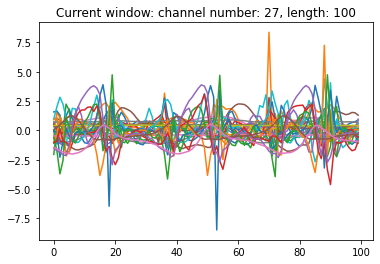

In [37]:
print('visualising the current test frame')
fig = plt.figure()
plt.title('Current window: channel number: 27, length: 100')
plt.plot(np.transpose(current_test_data0))
plt.show()


In [38]:
print('defining a a query function, that can output the probability distribution given the current frame')
def query_model(current_test_data, model):
    if network_type=='CNN' or network_type=='ConvLSTM':
        print('reshaping test_data')
        current_test_data_4d = np.reshape(current_test_data, (-1, dim, win_len, 1))
        print('working on the prediction...')
        prob_dist = model.predict(current_test_data_4d)
    else: 
        print('current version only work on CNN/ConvLSTM structure!')
    return prob_dist


defining a a query function, that can output the probability distribution given the current frame


In [39]:
prob_dist = query_model(current_test_data0, model)
print('given the query frame, the output probabilities for all classes:')
print(prob_dist)


reshaping test_data
working on the prediction...
given the query frame, the output probabilities for all classes:
[[1.2123281e-03 1.0749808e-03 7.5843203e-04 9.8793977e-04 1.0211216e-02
  7.4902792e-03 1.0012563e-03 9.6912885e-01 6.0437061e-03 4.6840167e-04
  6.1601488e-04 1.0066082e-03]]


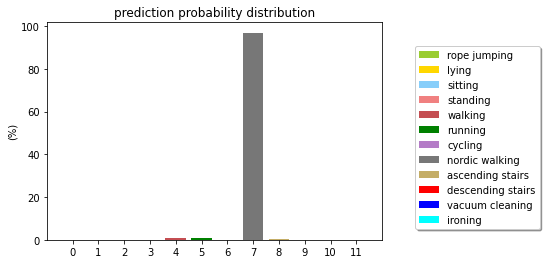

In [40]:
c = np.arange(cNum) # cNum: number of classes, 12 for PAMAP2 dataset
color_set = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral',
        '#C44E52', 'green', '#B47CC7','#777777','#C4AD66','red', 
                  'blue',  'cyan', 'magenta',
                '#FBC15E','#56B4E9','#4878CF','#FFFEA3' ]


colors = color_set[:cNum]
fig, ax = plt.subplots()
_bar = ax.bar(c, 100*prob_dist.flatten(), color=colors)
ax.legend(_bar, (labels_PAMAP2), loc=(1.1, 0.05), shadow=True, borderaxespad=10)
ax.set_ylabel('(%)')
ax.set_title('prediction probability distribution')
ax.set_xticks(c)
plt.show()

In [41]:
y_pred = np.argmax(prob_dist, axis=1)
print('predicted activity: '+labels_PAMAP2[int(y_pred)])

predicted activity: nordic walking


In [42]:
print('ground truth: '+labels_PAMAP2[int(y_test[rand_test_id])])


ground truth: nordic walking


**Correct prediction**